In [1]:
import numpy as np                    # Biblioteca para manipulação númerica
import matplotlib.pyplot as plt       # Biblioteca para visualização e gráficos
import scipy                          # Biblioteca de funções estatísticas
import quadpy                         # Biblioteca de integração numérica
import math                           # Biblioteca com funções matemáticas

In [2]:
p0 = 1
k = 6
ts = 0.625e-3
#b = 0.00001
B = [150e-6,200e-6,250e-6,30e-6,100e-6,10e-6]
alfa = 1.5e-6
#alfa = 1e-6
sample_t = 690e-6
w_a = 1
w_b = 1e9
w_n = 100
ksi = 0.922
w = np.geomspace(w_a,w_b,w_n)
lbd = np.sqrt(alfa/(w))
lin_precision = 0.01
pla_precision = 0.0001

**p0** : the rms power (p_rms) of the the heater (W/m)

**k** : thermal conductivity of the heater material (W/m.K)

Notar que **k** é fortemente dependente da temperatura, então aqui usamos **k** em temperatura ambiente ~300 Kelvin.

**b** : half-width of the heater (m)

**alfa** : thermal diffusivity of the sample material((m)^2/s) (8.81e-5 for PbTe [3] Phys. Rev. B 39, 7967)

**w_a** : graph starting frequêncy (2.w) (rad/s)

**w_b** : graph ending frequêncy (2.w) (rad/s)

**w_n** : number of frequêncy points calculated for the plot

**ksi** : fitting constant of the linear approximation ([2] David De Koninck)

**w** : Generate a sequence of values for the frequency to be evaluated.

**lbd** : Transform the frequency into the lambda (Termal Penetration Depth - (alfa/2w)^1/2 (m))

The maximum heater width is defined by ts>25b

---



In [3]:
def calculate(w_n,b, lin_precision, pla_precision):
  y_r = np.zeros(w_n)
  y_i = np.zeros(w_n)
  error = 0
  for t in range(w_n):
      w0 = w[t]
      # Integration done by quadpy.c1.integrate_adaptive() for each frequency.
      I, error_estimate = quadpy.c1.integrate_adaptive(
          lambda eta: (p0/(np.pi*k))*((np.power(np.sin(eta*b),2))/((np.power(eta*b,2))*(np.sqrt((np.power(eta,2)) + (np.power((np.sqrt((w0*1j)/alfa)),2))))))
          , [1e-10, 1e10],1e-10)
      if error < error_estimate:
          error = error_estimate
      y_r[t] = I.real
      y_i[t] = I.imag
  y = [y_r, y_i]

  # Calculated plot for the planar regime of DT. 
  planar_r = ((p0/(2*b))/(k*(np.sqrt((w*1j)/alfa)))).real
  planar_i = ((p0/(2*b))/(k*(np.sqrt((w*1j)/alfa)))).imag
  planar = [planar_r, planar_i]
  # Calculated plot for the linear regime of DT. The constant 0.922 is given by David De Koninck, 2-15.
  linear_r = (-(p0/(np.pi*k))*(np.log((np.sqrt((w*1j)/alfa))*b)-ksi)).real
  linear_i = (-(p0/(np.pi*k))*(np.log((np.sqrt((w*1j)/alfa))*b)-ksi)).imag
  linear = [linear_r, linear_i]
  # Calculated axis for the lambda = (alfa/2w)^(1/2) (um)
  lbd = np.sqrt(alfa/(w))*1e6

  # Finding the frequency limit for the linear regime.
  err_r_l = abs(y_r[0] - linear_r[0])
  err_i_l = abs(y_i[0] - linear_i[0])
  l = 1
  while err_r_l < lin_precision and err_i_l < lin_precision:
      if (l>=w_n):
        break
      else:
        err_r_l = abs(y_r[l] - linear_r[l])
        err_i_l = abs(y_i[l] - linear_i[l])
        l = l+1
  # Finding the frequency limit for the planar regime.
  err_r_p = abs(y_r[0] - planar_r[0])
  err_i_p = abs(y_i[0] - planar_i[0])
  v = 1
  while err_r_p > pla_precision and err_i_p > pla_precision:
      if (v>=w_n):
        break
      else:
        err_r_p = abs(y_r[v] - planar_r[v])
        err_i_p = abs(y_i[v] - planar_i[v])
        v = v+1
  lm = [l,v]

  return y, linear, planar, lm

This function creates an array of real and imaginary values for the average temperature in the heater using numerical integration (*quadpy* library) using an adaptative quadrature integration algorithm. It returns 2 arrays of **w_n** values each, containing the real and imaginary values. 

---



In [4]:
def plot():
  fig = plt.figure(figsize=(6,4), dpi=150)
  minf = (25*alfa)/(4*np.pi*(sample_t)**2)
  minf_hz = ((alfa)/(100*np.pi*(minf)**2))/(2*math.pi)
  print(minf/(2*math.pi))
  #maxf = (alfa)/(100*np.pi*(B)**2)
  ax = fig.add_axes([0,0,1,1])
  a2 = ax.twiny()
  ax.set_xscale("log")
  a2.set_xscale("log")
  min_w = (alfa/2)*(5/ts)**2
  #ax.axvspan(w_a, minf, facecolor='blue', alpha=0.2, label=r'Minimum Frequency '+str(format(minf_hz,'.1f'))+' Hz')
  #ax.axvspan(w[v], w_b, facecolor='red', alpha=0.2, label=r'$\lambda$ >> b - Planar Regime')
  a2.invert_xaxis()
  ax.set_ylim(0,0.25)
  for k in B:
    if (k == 150e-6):
      Y,L,P,LM = calculate(w_n,k,lin_precision, pla_precision)
      #ax.plot(w, Y[0],"-", label=r'$\Delta T$'+r' In-phase - $b_h$ = '+str(k)+' m')
      #ax.plot(w, L[0],"--", label=r'$\Delta T$'+' Linear Approx. - $b_h$ = '+str(k)+' m')
      ax.plot(w, Y[0],"-", label=r'$\Delta T$'+r' In Phase - $b_h$ = '+str(k)+' m')
      ax.plot(w, L[0],"--", label=r'$\Delta T$'+' Linear Aprox.')
      a2.plot(lbd, Y[0],"-")
      #ax.axvline(x=(alfa)/(100*np.pi*(k)**2), ls=":", color=plt.gca().lines[-1].get_color(), label=r'Maximum frequency: '+str(int(((alfa)/(100*np.pi*(k)**2))/(2*math.pi)))+' Hz')
    else:
      Y,L,P,LM = calculate(w_n,k,lin_precision, pla_precision)
      #ax.plot(w, Y[0],"-", label=r'$\Delta T$'+r' In-phase - $b_h$ = '+str(k)+' m')
      #ax.plot(w, L[0],"--", label=r'$\Delta T$'+' Linear Approx. - $b_h$ = '+str(k)+' m')
      ax.plot(w, Y[0],".",markersize=3,label=r'$\Delta T$'+r' In Phase - $b_h$ = '+str(k)+' m')
      #a2.plot(lbd, Y[0],"-")
      #ax.axvline(x=(alfa)/(100*np.pi*(k)**2), ls=":", color=plt.gca().lines[-1].get_color(), label=r'Maximum frequency: '+str(int(((alfa)/(100*np.pi*(k)**2))/(2*math.pi)))+' Hz')
  a2.set_xlabel('Thermal Penetration Depth, '+r'$ \lambda = (\alpha/2\omega)^{1/2}$'+' '+'$(m)$')
  ax.set_xlabel('Thermal Oscillations Frequency, '+r'$2 \omega$'+' (rad/s)')
  ax.set_ylabel('Heater Temperature Variation '+r'$\Delta T$'+' (K)')
  ax.legend()
  plt.show()

0.9975699397678187


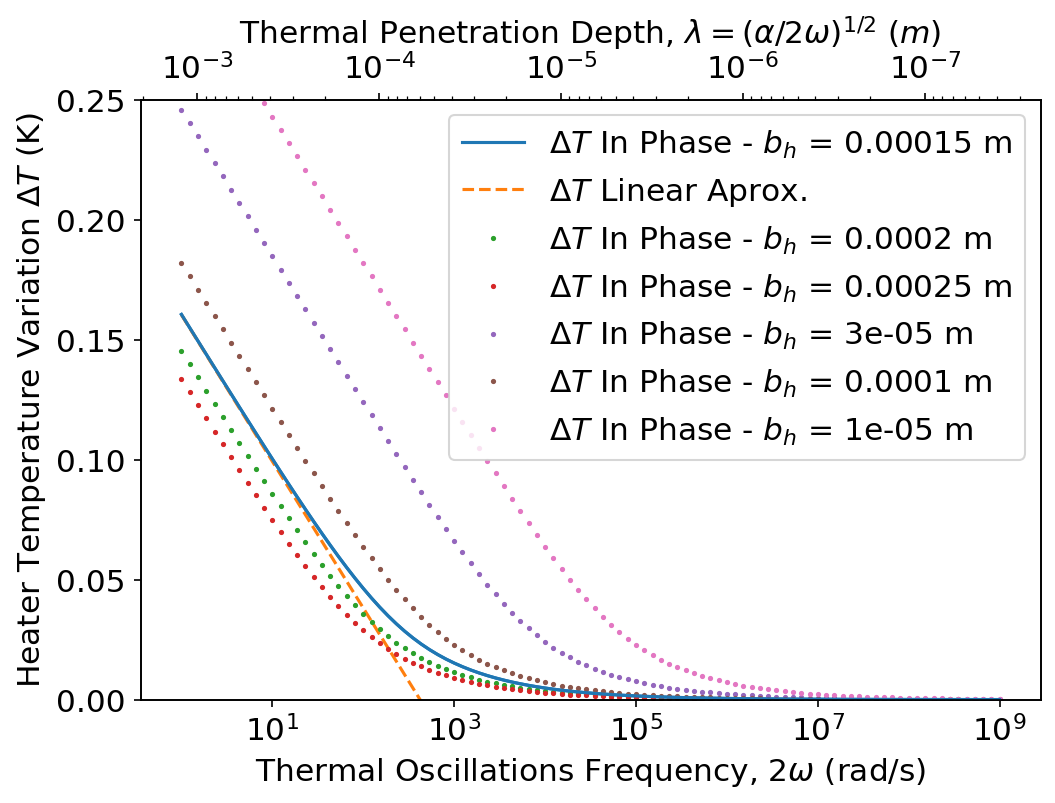

In [5]:
plt.rcParams['font.size'] = 15
plot()

In [6]:
l = [75,68,59,55,81,86,90,95,87,60,57,63,76,96]
f = np.array(l)
print(np.mean(f)/2)
print(np.std(f)/2)
print(np.var(f)/len(f))

37.42857142857143
7.027642214999339
14.110787172011664


In [7]:
p0 = 1
k = 6
ts = 0.625e-3
#b = 0.00001
B = [150e-6,200e-6,250e-6,30e-6,100e-6,10e-6]
alfa = 1.5e-6
#alfa = 1e-6
sample_t = 690e-6
w_a = 1
w_b = 1e9
w_n = 100
ksi = 0.922
w = np.geomspace(w_a,w_b,w_n)
lbd = np.sqrt(alfa/(w))
lin_precision = 0.01
pla_precision = 0.0001

**p0** : the rms power (p_rms) of the the heater (W/m)

**k** : thermal conductivity of the heater material (W/m.K)

Notar que **k** é fortemente dependente da temperatura, então aqui usamos **k** em temperatura ambiente ~300 Kelvin.

**b** : half-width of the heater (m)

**alfa** : thermal diffusivity of the sample material((m)^2/s) (8.81e-5 for PbTe [3] Phys. Rev. B 39, 7967)

**w_a** : graph starting frequêncy (2.w) (rad/s)

**w_b** : graph ending frequêncy (2.w) (rad/s)

**w_n** : number of frequêncy points calculated for the plot

**ksi** : fitting constant of the linear approximation ([2] David De Koninck)

**w** : Generate a sequence of values for the frequency to be evaluated.

**lbd** : Transform the frequency into the lambda (Termal Penetration Depth - (alfa/2w)^1/2 (m))

The maximum heater width is defined by ts>25b

---



In [8]:
def calculate(w_n,b, lin_precision, pla_precision):
  y_r = np.zeros(w_n)
  y_i = np.zeros(w_n)
  error = 0
  for t in range(w_n):
      w0 = w[t]
      # Integration done by quadpy.c1.integrate_adaptive() for each frequency.
      I, error_estimate = quadpy.c1.integrate_adaptive(
          lambda eta: (p0/(np.pi*k))*((np.power(np.sin(eta*b),2))/((np.power(eta*b,2))*(np.sqrt((np.power(eta,2)) + (np.power((np.sqrt((w0*1j)/alfa)),2))))))
          , [1e-10, 1e10],1e-10)
      if error < error_estimate:
          error = error_estimate
      y_r[t] = I.real
      y_i[t] = I.imag
  y = [y_r, y_i]

  # Calculated plot for the planar regime of DT. 
  planar_r = ((p0/(2*b))/(k*(np.sqrt((w*1j)/alfa)))).real
  planar_i = ((p0/(2*b))/(k*(np.sqrt((w*1j)/alfa)))).imag
  planar = [planar_r, planar_i]
  # Calculated plot for the linear regime of DT. The constant 0.922 is given by David De Koninck, 2-15.
  linear_r = (-(p0/(np.pi*k))*(np.log((np.sqrt((w*1j)/alfa))*b)-ksi)).real
  linear_i = (-(p0/(np.pi*k))*(np.log((np.sqrt((w*1j)/alfa))*b)-ksi)).imag
  linear = [linear_r, linear_i]
  # Calculated axis for the lambda = (alfa/2w)^(1/2) (um)
  lbd = np.sqrt(alfa/(w))*1e6

  # Finding the frequency limit for the linear regime.
  err_r_l = abs(y_r[0] - linear_r[0])
  err_i_l = abs(y_i[0] - linear_i[0])
  l = 1
  while err_r_l < lin_precision and err_i_l < lin_precision:
      if (l>=w_n):
        break
      else:
        err_r_l = abs(y_r[l] - linear_r[l])
        err_i_l = abs(y_i[l] - linear_i[l])
        l = l+1
  # Finding the frequency limit for the planar regime.
  err_r_p = abs(y_r[0] - planar_r[0])
  err_i_p = abs(y_i[0] - planar_i[0])
  v = 1
  while err_r_p > pla_precision and err_i_p > pla_precision:
      if (v>=w_n):
        break
      else:
        err_r_p = abs(y_r[v] - planar_r[v])
        err_i_p = abs(y_i[v] - planar_i[v])
        v = v+1
  lm = [l,v]

  return y, linear, planar, lm

This function creates an array of real and imaginary values for the average temperature in the heater using numerical integration (*quadpy* library) using an adaptative quadrature integration algorithm. It returns 2 arrays of **w_n** values each, containing the real and imaginary values. 

---



In [9]:
def plot():
  fig = plt.figure(figsize=(6,4), dpi=150)
  minf = (25*alfa)/(4*np.pi*(sample_t)**2)
  minf_hz = ((alfa)/(100*np.pi*(minf)**2))/(2*math.pi)
  print(minf/(2*math.pi))
  #maxf = (alfa)/(100*np.pi*(B)**2)
  ax = fig.add_axes([0,0,1,1])
  a2 = ax.twiny()
  ax.set_xscale("log")
  a2.set_xscale("log")
  min_w = (alfa/2)*(5/ts)**2
  #ax.axvspan(w_a, minf, facecolor='blue', alpha=0.2, label=r'Minimum Frequency '+str(format(minf_hz,'.1f'))+' Hz')
  #ax.axvspan(w[v], w_b, facecolor='red', alpha=0.2, label=r'$\lambda$ >> b - Planar Regime')
  a2.invert_xaxis()
  ax.set_ylim(0,0.25)
  for k in B:
    if (k == 150e-6):
      Y,L,P,LM = calculate(w_n,k,lin_precision, pla_precision)
      #ax.plot(w, Y[0],"-", label=r'$\Delta T$'+r' In-phase - $b_h$ = '+str(k)+' m')
      #ax.plot(w, L[0],"--", label=r'$\Delta T$'+' Linear Approx. - $b_h$ = '+str(k)+' m')
      ax.plot(w, Y[0],"-", label=r'$\Delta T$'+r' In Phase - $b_h$ = '+str(k)+' m')
      ax.plot(w, L[0],"--", label=r'$\Delta T$'+' Linear Aprox.')
      a2.plot(lbd, Y[0],"-")
      #ax.axvline(x=(alfa)/(100*np.pi*(k)**2), ls=":", color=plt.gca().lines[-1].get_color(), label=r'Maximum frequency: '+str(int(((alfa)/(100*np.pi*(k)**2))/(2*math.pi)))+' Hz')
    else:
      Y,L,P,LM = calculate(w_n,k,lin_precision, pla_precision)
      #ax.plot(w, Y[0],"-", label=r'$\Delta T$'+r' In-phase - $b_h$ = '+str(k)+' m')
      #ax.plot(w, L[0],"--", label=r'$\Delta T$'+' Linear Approx. - $b_h$ = '+str(k)+' m')
      ax.plot(w, Y[0],".",markersize=3,label=r'$\Delta T$'+r' In Phase - $b_h$ = '+str(k)+' m')
      #a2.plot(lbd, Y[0],"-")
      #ax.axvline(x=(alfa)/(100*np.pi*(k)**2), ls=":", color=plt.gca().lines[-1].get_color(), label=r'Maximum frequency: '+str(int(((alfa)/(100*np.pi*(k)**2))/(2*math.pi)))+' Hz')
  a2.set_xlabel('Thermal Penetration Depth, '+r'$ \lambda = (\alpha/2\omega)^{1/2}$'+' '+'$(m)$')
  ax.set_xlabel('Thermal Oscillations Frequency, '+r'$2 \omega$'+' (rad/s)')
  ax.set_ylabel('Heater Temperature Variation '+r'$\Delta T$'+' (K)')
  ax.legend()
  plt.show()

0.9975699397678187


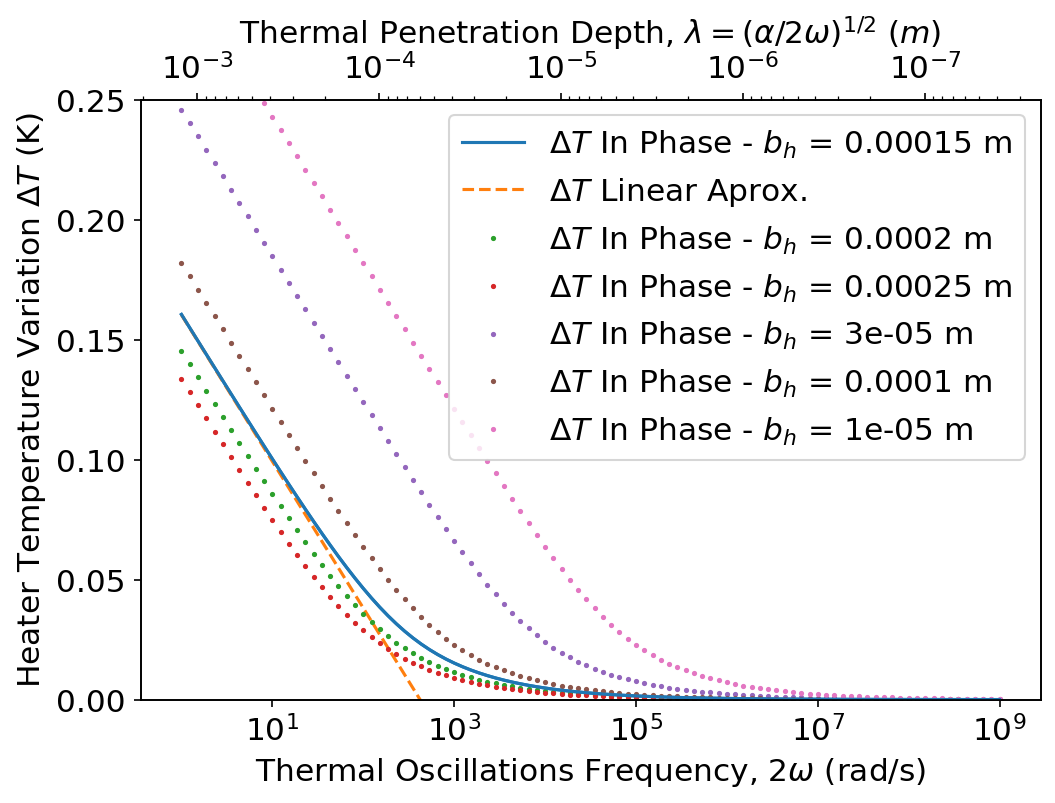

In [10]:
plt.rcParams['font.size'] = 15
plot()

In [ ]:
l = [75,68,59,55,81,86,90,95,87,60,57,63,76,96]
f = np.array(l)
print(np.mean(f)/2)
print(np.std(f)/2)
print(np.var(f)/len(f))

37.42857142857143
7.027642214999339
14.110787172011664
